In [1]:
import os     
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation,Flatten,Dense,Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
tf.__version__

'2.3.0'

In [2]:
classes = ["A", "B", "C"]

In [3]:
idg=ImageDataGenerator(rescale=1./255,dtype = ('float32'),
                                   rotation_range=40,        #隨機旋轉0~40度
                                   width_shift_range=0.4,    #隨機水平偏移的幅度  參數0~1之間  隨機偏移距離0~圖片長*參數
                                   height_shift_range=0.4,   #隨機垂直偏移的幅度  參數0~1之間  隨機偏移距離0~圖片寬*參數
                                   shear_range=0.4,         #按比例平移
                                    fill_mode='nearest',
                                   validation_split=0.2,
                                   zoom_range=0.4,          #隨機縮放的幅度 參數0~1放大   大於1變小
                                   horizontal_flip=True)
idg2=ImageDataGenerator(rescale=1./255)

In [4]:
train_directory=idg.flow_from_directory(
    directory=os.path.join("./train"),
    target_size=(224, 224),
    classes=classes,
    batch_size=20,
    class_mode='categorical',
    subset='training')

Found 2055 images belonging to 3 classes.


In [5]:
validation_directory=idg.flow_from_directory(
    directory=os.path.join("./train"),
    target_size=(224, 224),
    classes=classes,
    batch_size=20,
    class_mode='categorical',
    subset='validation')

Found 511 images belonging to 3 classes.


In [6]:
model = Sequential()
model.add(tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224 ,224 ,3)))
#model.add(tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224 ,224 ,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
print(model.summary())

2022-01-13 01:00:56.243949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 01:00:56.253722: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f95fc5f6720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-13 01:00:56.253732: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              51381248  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 54,613,187
Trainable params: 54,591,299
Non-trainable params: 21,888
_______________________________________

In [7]:
op=Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=op, metrics=['accuracy'])

In [8]:
stop=EarlyStopping(monitor='val_loss', patience=3,verbose=1)
model_path = './MobileNetmodel/savemodel.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=0)

In [9]:
fit_history=model.fit_generator(train_directory,
                                steps_per_epoch= 15,
                                epochs=5,
                                validation_data=validation_directory,
                                validation_steps=5,
                                callbacks=[stop,checkpoint]) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 3.3080 - accuracy: 0.5333

/Users/taeyeon/Library/Python/3.8/lib/python/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 15s 1s/step - loss: 3.3080 - accuracy: 0.5333 - val_loss: 3.5123 - val_accuracy: 0.5100
Epoch 2/5
15/15 [==============================] - 15s 969ms/step - loss: 2.2471 - accuracy: 0.6900 - val_loss: 1.9719 - val_accuracy: 0.6900
Epoch 3/5
15/15 [==============================] - 15s 979ms/step - loss: 1.9021 - accuracy: 0.7633 - val_loss: 0.5726 - val_accuracy: 0.8700
Epoch 4/5
15/15 [==============================] - 13s 877ms/step - loss: 1.2661 - accuracy: 0.8033 - val_loss: 1.0951 - val_accuracy: 0.8400
Epoch 5/5
15/15 [==============================] - 13s 870ms/step - loss: 1.4808 - accuracy: 0.7900 - val_loss: 1.3233 - val_accuracy: 0.7900


In [10]:
model = load_model('./MobileNetmodel/savemodel.h5')

In [11]:
import matplotlib.pyplot as plt
def show_train_history(fit_history,train,validation):
    plt.plot(fit_history.history[train])
    plt.plot(fit_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

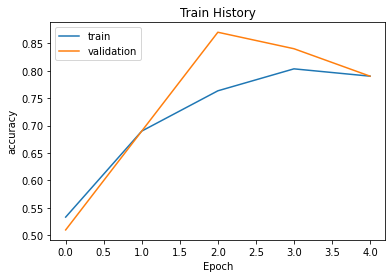

In [12]:
show_train_history(fit_history,'accuracy','val_accuracy')

In [13]:
test_path = './test/test.csv'
df = pd.read_csv(test_path, sep=',', skiprows=1,  names=['id', 'label'])
df['id'] = df['id'].astype('str')

test_datagen = ImageDataGenerator(rescale=1/255.)

test_directory = test_datagen.flow_from_dataframe(df, './test/testtest',
                                                x_col='id', y_col='label',
                                                target_size=(224,224),
                                                interpolation='bicubic',
                                                class_mode=None,
                                                shuffle=False,
                                                batch_size=1)

Found 102 validated image filenames.


In [14]:
predict = model.predict_generator(test_directory,verbose=1)
predict[:10]

Instructions for updating:
Please use Model.predict, which supports generators.
102/102 [==============================] - 4s 44ms/step


array([[9.9999988e-01, 9.5816759e-09, 9.1610048e-08],
       [1.7036886e-06, 9.9999797e-01, 3.3540672e-07],
       [4.8207158e-09, 4.4939884e-07, 9.9999952e-01],
       [9.9985182e-01, 1.7976290e-05, 1.3021026e-04],
       [9.9999905e-01, 4.3414483e-10, 1.0048869e-06],
       [1.0000000e+00, 3.6331286e-08, 3.2207985e-09],
       [9.6620697e-01, 3.3782519e-02, 1.0460561e-05],
       [8.9242601e-01, 1.0757338e-01, 6.3579063e-07],
       [9.8969412e-01, 1.0304792e-02, 1.0372951e-06],
       [9.8969412e-01, 1.0304792e-02, 1.0372951e-06]], dtype=float32)

In [15]:
pred_max = np.argmax(predict, axis = 1)
print(len(pred_max))
pred_max[:10]

102


array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0])

In [16]:
label_dict = {0: "A", 1: "B", 2: "C"}

In [17]:
test_label = df['label']
print(label_dict)
pd.crosstab(test_label,pred_max,
            rownames=['label'],colnames=['predict'])

{0: 'A', 1: 'B', 2: 'C'}


predict,0,1,2
label,,,
0,30,3,1
1,0,34,0
2,0,0,34


In [18]:
def show_Predicted_Probability(i):
    print('label:',label_dict[test_label[i]],
          'predict:',label_dict[pred_max[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(test_directory[i],(224, 224,3)))
    plt.show()
    for j in range(2):
        print(label_dict[j]+' Probability:%1.5f'%(predict[i][j]))

label: A predict: A


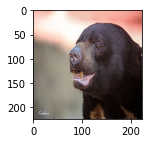

A Probability:0.99985
B Probability:0.00002


In [19]:
show_Predicted_Probability(3)

In [20]:
df = pd.DataFrame({'label':test_label, 'predict':pred_max})
df[(df.label==1)&(df.predict==0)]
# df[(df.label == 0) & (df.predict != 0) | (df.label == 1) & (df.predict != 1) | (df.label == 2) & (df.predict != 2)]


,label,predict


label: A predict: A


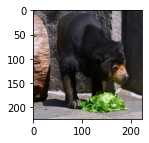

A Probability:0.99999
B Probability:0.00001


In [21]:
show_Predicted_Probability(24)

In [22]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
file_path = './test/testtest/bear_one3.jpg'
img = image.load_img(file_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print('cat:',model.predict(x)[0][1])  # predict[0] = [0.8469923, 0.1530407]
print('dog:',model.predict(x)[0][0])

cat: 0.0010642309
dog: 1.3840615e-09


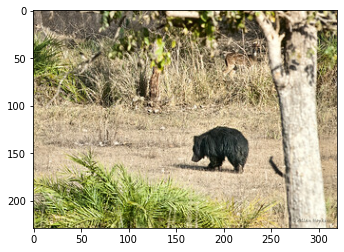

In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_bgr = cv2.imread('./test/testtest/bear_two4.jpg') # open CV 讀入格式  BGR 要轉成 RGB 才能正常顯示

img_rgb = img_bgr[:,:,::-1]  # BGR  --> RGB

plt.imshow(img_rgb)
plt.show()